# Initialization

In [1]:
!pip install rdflib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.7 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/IntelligentGraph')

In [ ]:
!pip install "git+https://github.com/Inova8/IntelligentGraph.git"

In [3]:
import IntelligentGraph
from IntelligentGraph import SCRIPT, IntelligentConjunctiveGraph

# Local Declarations

In [10]:
from rdflib.namespace import Namespace,DefinedNamespace
from rdflib import Graph, URIRef, term
from typing import Generator ,Tuple,Optional

_TriplePatternType = Tuple[
    Optional["_SubjectType"], Optional["_PredicateType"], Optional["_ObjectType"]
]

_ContextType = Graph
class SCRIPT(DefinedNamespace):
  """
  SCRIPT vocabulary

  The SCRIPT RDF vocabulary provides some aditional datatypes for conveniently handling scripts
  It also contains the SCRIPT evaluation engine

  Date: 2023-12-19

  """
  _fail = True
  _NS = Namespace("http://inova8.com/script/")

  python=URIRef("http://inova8.com/script/python")
  error=URIRef("http://inova8.com/script/error")

  def __init__( self):
    python_type =self.python
    error_type =self.error
    if( self.python not in  term._toPythonMapping): term.bind(self.python, str)
    if( self.error not in  term._toPythonMapping): term.bind(self.error, str)

  def _handleReturn(s,p,returnResult):
      if(returnResult is not None ):
        if(isinstance(returnResult ,Generator)):
          yield returnResult
        elif(isinstance(returnResult ,term.Node)):
          yield s, p , returnResult
        else:
          yield s, p ,Literal(returnResult)
      else:
        yield s, p ,Literal("Error=Script does not return _return value", datatype=SCRIPT.error)

  def _eval(  self,
        triple: _TriplePatternType,
        ctx :Optional[_ContextType]=None
    ) -> Generator["_TripleType", None, None]:
    s, p, o = triple
    inputs = globals() #globals
    inputs['g']=self
    inputs['s']=s
    inputs['p']=p
    inputs['o']=o
    inputs['ctx']=ctx
    result={'_result':None} #locals
    try:
      exec(o,inputs,result)
    except BaseException as err:
      yield s, p ,Literal("Error="+str(err)+ "\nCode = "+ str(o), datatype=SCRIPT.error)
    #yield SCRIPT.handleReturn(s,p,result['_result'])
    if(result['_result'] is not None ):
      if(isinstance(result['_result'] ,Generator)):
        yield result['_result']
      elif(isinstance(result['_result'] ,term.Node)):
        yield s, p , result['_result']
      else:
        yield s, p ,Literal(result['_result'])
    else:
      yield s, p ,Literal("Error=Script does assign _return value or value assigned is None. \nCode ="+ str(o), datatype=SCRIPT.error)


  def scriptEvaluator(self, _s, _p, _o,  _ctx :Optional[_ContextType]=None):
    resultGenerator = next(SCRIPT._eval(self,triple=(_s, _p, _o)), _ctx)
    if(isinstance(resultGenerator,Generator)):
      try:
        #for ( _es, _ep, _eo) in resultGenerator:
        #  yield ( _es, _ep, _eo)
        for triple in resultGenerator:
          if (isinstance(triple, tuple)):
            if ( isinstance(triple[0],term.Node) and isinstance(triple[1],term.Node) and isinstance(triple[2],term.Node) ):
              yield triple
            else:
              yield _s, _p ,Literal("Error=tuple but not all elements are term.Node"+ "\nCode = "+ str(_o), datatype=SCRIPT.error)
          else:
            yield _s, _p ,Literal("Error=incomplete tuple"+ "\nCode = "+ str(_o), datatype=SCRIPT.error)
      except BaseException as err:
        yield _s, _p ,Literal("Error="+str(err)+ "\nCode = "+ str(_o), datatype=SCRIPT.error)
    else:
      yield resultGenerator

In [3]:
from rdflib import Graph, ConjunctiveGraph, Dataset
from rdflib.paths import Path
from typing import Generator,Tuple,Optional,Union ,List
from rdflib.term import Node

_SubjectType = Node
_PredicateType = Node
_ObjectType = Node
_TripleType = Tuple["_SubjectType", "_PredicateType", "_ObjectType"]
_TripleSelectorType = Tuple[
    Optional["_SubjectType"],
    Optional[Union["Path", "_PredicateType"]],
    Optional["_ObjectType"],
]
_TriplePathType = Tuple["_SubjectType", Path, "_ObjectType"]
_TripleOrTriplePathType= Union["_TripleType", "_TriplePathType"]

_QuadSelectorType = Tuple[
    Optional["_SubjectType"],
    Optional[Union["Path", "_PredicateType"]],
    Optional["_ObjectType"],
    Optional["_ContextType"],
]
_TripleOrQuadSelectorType = Union["_TripleSelectorType", "_QuadSelectorType"]
_TriplePathPatternType = Tuple[Optional["_SubjectType"], Path, Optional["_ObjectType"]]
_QuadPathPatternType = Tuple[
    Optional["_SubjectType"],
    Path,
    Optional["_ObjectType"],
    Optional["_ContextType"],
]
_TripleOrQuadPatternType = Union["_TriplePatternType", "_QuadPatternType"]
_OptionalQuadType = Tuple[
    "_SubjectType", "_PredicateType", "_ObjectType", Optional["_ContextType"]
]
class IntelligentGraph(Graph):
  """An Intelligent RDF Graph, inherited from Graph

  Supports triples with SCRIPT-valued objects, literals of datatype SCRIPT.python.

  Instead of returning the object literal, the Python script within that literal is executed.

  The Python script can return a scalar, which is interpreted as the node replacement value for the scipt.
  Alternatively the Pythobn scrript can yield a list of tuples.

  In the event of a script execution error, the error message os returned as the literal value of the object with datatype SCRIPT.error
  """
  def triples(
          self,
          triple: _TripleSelectorType,
      ) -> Generator[_TripleOrTriplePathType, None, None]:
          """Generator over the triple store

          Returns triples that match the given triple pattern. If triple pattern
          does not provide a context, all contexts will be searched.
          """
          s, p, o = triple
          if isinstance(p, Path):
              for _s, _o in p.eval(self, s, o):
                  yield _s, p, _o
          else:
            for (_s, _p, _o), cg in self.store.triples((s, p, o), context=self):
              # __store not visible so replaced with store
              if (isinstance(_o, Literal) and (_o.datatype ==  SCRIPT.python)):
                for ss,pp,oo in  SCRIPT.scriptEvaluator(self, _s, _p, _o):
                  yield ss,pp,oo

              else:
                yield _s, _p, _o

#_ContextType = IntelligentGraph

class IntelligentConjunctiveGraph(ConjunctiveGraph):
    def triples(
        self,
        triple_or_quad: _TripleOrQuadSelectorType,
        context: Optional[_ContextType] = None,
    ) -> Generator[_TripleOrTriplePathType, None, None]:
        """
        Iterate over all the triples in the entire conjunctive graph

        For legacy reasons, this can take the context to query either
        as a fourth element of the quad, or as the explicit context
        keyword parameter. The kw param takes precedence.
        """

        s, p, o, c = self._spoc(triple_or_quad)
        context = self._graph(context or c)

        if self.default_union:
            if context == self.default_context:
                context = None
        else:
            if context is None:
                context = self.default_context

        if isinstance(p, Path):
            if context is None:
                context = self

            for s, o in p.eval(context, s, o):
                yield s, p, o
        else:
            for (s, p, o), cg in self.store.triples((s, p, o), context=context):
              if (isinstance(o, Literal) and (o.datatype ==  SCRIPT.python)):
                for ss,pp,oo in  SCRIPT.scriptEvaluator(self, s, p, o,cg):
                  yield ss,pp,oo

              else:
                yield s, p, o

    def quads(
        self, triple_or_quad: Optional[_TripleOrQuadPatternType] = None
    ) -> Generator[_OptionalQuadType, None, None]:
        """Iterate over all the quads in the entire conjunctive graph"""

        s, p, o, c = self._spoc(triple_or_quad)

        for (s, p, o), cg in self.store.triples((s, p, o), context=c):
            for ctx in cg:
              #yield s, p, o, ctx
              if (isinstance(o, Literal) and (o.datatype ==  SCRIPT.python)):
                for ss,pp,oo in  SCRIPT.scriptEvaluator(self, s, p, o, ctx):
                  yield ss,pp,oo,ctx

              else:
                yield s, p, o, ctx

    def triples_choices(
        self,
        triple: Union[
            Tuple[List[_SubjectType], _PredicateType, _ObjectType],
            Tuple[_SubjectType, List[_PredicateType], _ObjectType],
            Tuple[_SubjectType, _PredicateType, List[_ObjectType]],
        ],
        context: Optional[_ContextType] = None,
    ) -> Generator[_TripleType, None, None]:
        """Iterate over all the triples in the entire conjunctive graph"""
        s, p, o = triple
        if context is None:
            if not self.default_union:
                context = self.default_context
        else:
            context = self._graph(context)
        # type error: Argument 1 to "triples_choices" of "Store" has incompatible type "Tuple[Union[List[Node], Node], Union[Node, List[Node]], Union[Node, List[Node]]]"; expected "Union[Tuple[List[Node], Node, Node], Tuple[Node, List[Node], Node], Tuple[Node, Node, List[Node]]]"
        # type error note: unpacking discards type info
        for (s1, p1, o1), cg in self.store.triples_choices((s, p, o), context=context):  # type: ignore[arg-type]
            #yield s1, p1, o1
            if (isinstance(o, Literal) and (o.datatype ==  SCRIPT.python)):
              for ss,pp,oo in  SCRIPT.scriptEvaluator(self, s1, p1, o1,cg):
                yield ss,pp,oo

            else:
              yield s1, p1, o1

class IntelligentDataset(IntelligentConjunctiveGraph):
  def _me():
    return None


In [4]:
#Monkey patching
'''
if __name__ == '__main__':
    # Import and use like this, other ways of import will not work.
    # Because other way imports method to your namespace and then change it in your namespace,
    # but you need to change it in the original namespace
    Graph.triples = IntelligentGraph.triples
'''

# Test Code

In [8]:
# Test graph
from rdflib import  Literal,   URIRef
from rdflib.namespace import RDF, FOAF , XSD


#g = IntelligentGraph()
g = IntelligentConjunctiveGraph()
#g = IntelligentDataset()

In [9]:
# Create an RDF URI node to use as the subject for multiple triples
ig = URIRef("http://inova8.com/ig")

# Add triples using store's add() method.
g.add((ig, RDF.type, FOAF.Person))
g.add((ig, FOAF.birthday, Literal("2021", lang="en")))
g.add((ig, FOAF.birthday, Literal("2020", lang="en")))
g.add((ig, FOAF.birthday, Literal("2010", lang="en")))

g.add((ig, FOAF.knows, Literal( """
_result=s
""" , datatype=SCRIPT.python)))

g.add((ig, FOAF.birthday, Literal( """
_result=2000
""" , datatype=SCRIPT.python)))

g.add((ig, FOAF.interest, Literal( """
def getInterest():
  for interest in range(1,4):
    yield (s, p, Literal(interest))
_result= getInterest()
""" , datatype=SCRIPT.python)))

g.add((ig, FOAF.img, Literal( """
_result= [1,2,3,4]
""" , datatype=SCRIPT.python)))

g.add((ig, FOAF.img, Literal( """
_result= str(ctx)
""" , datatype=SCRIPT.python)))

g.add((ig, FOAF.img, Literal( """
_result=  Literal( '_result = 42', datatype=SCRIPT.python)""" , datatype=SCRIPT.python)))


g.add((ig, FOAF.img, Literal( """
_result= ctx
""" , datatype=SCRIPT.python)))

g.add((ig, FOAF.age, Literal( """
from rdflib.namespace import FOAF
def getAges():
  for triple in g.triples( (s , FOAF.birthday, None)):
    yob= triple[2]
    #&
    ageYears = Literal(2024-int(yob))
    yield (s, FOAF.age, ageYears)
_result= getAges()
""" , datatype=SCRIPT.python)))

g.add((ig, URIRef("http://xmlns.com/foaf/0.1/birthdayCount"), Literal( """
from rdflib.namespace import FOAF
def getCount():
  birthdayCount=sum(1 for _ in g.triples( (s, FOAF.birthday, None)))
  yield (s, p, Literal(birthdayCount))
_result= getCount()
""" , datatype=SCRIPT.python)))

g.add((ig, URIRef("http://xmlns.com/foaf/0.1/averageAge"), Literal( """
from rdflib.namespace import  FOAF
def getAverageAge():
  averageAge=0
  numberAge =0
  averageAgeIRI= p
  for triple in g.triples( (s , FOAF.age, None)):
    averageAge+= int(triple[2] )
    numberAge+= 1
  yield (s, averageAgeIRI, Literal(averageAge/numberAge))
_result= getAverageAge()
""" , datatype=SCRIPT.python)))

<Graph identifier=Nbb47b09defc9435ba40f591184d4607b (<class 'IntelligentGraph.IntelligentConjunctiveGraph'>)>

# Test Queries

In [41]:
for triple in g.triples( (ig , None, None)):
    print(triple)

(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Person'))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/birthday'), rdflib.term.Literal('2021', lang='en'))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/birthday'), rdflib.term.Literal('2020', lang='en'))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/birthday'), rdflib.term.Literal('2010', lang='en'))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/birthday'), rdflib.term.Literal('2000', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/knows'), rdflib.term.URIRef('http://inova8.com/ig'))
(rdflib.term.URIRef('http://inova8.com/ig'), rdfli

In [23]:
test_query = "describe <http://inova8.com/ig>"
for triple in g.query(test_query):
    print(triple)

(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/interest'), rdflib.term.Literal('3', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/birthday'), rdflib.term.Literal('2000', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/age'), rdflib.term.Literal('14', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/interest'), rdflib.term.Literal('2', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))
(rdflib.term.URIRef('http://inova8.com/ig'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/age'), rdflib.term.Literal('4', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer'

In [24]:
g.serialize(format="n3")

'@prefix foaf: <http://xmlns.com/foaf/0.1/> .\n@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n\n<http://inova8.com/ig> a foaf:Person ;\n    foaf:age 3,\n        4,\n        14,\n        24 ;\n    foaf:averageAge 1.125e+01 ;\n    foaf:birthday 4,\n        2000,\n        "2010"@en,\n        "2020"@en,\n        "2021"@en ;\n    foaf:img "[1, 2, 3, 4]" ;\n    foaf:interest 1,\n        2,\n        3 ;\n    foaf:knows <http://inova8.com/ig> .\n\n'

# Test Visualization

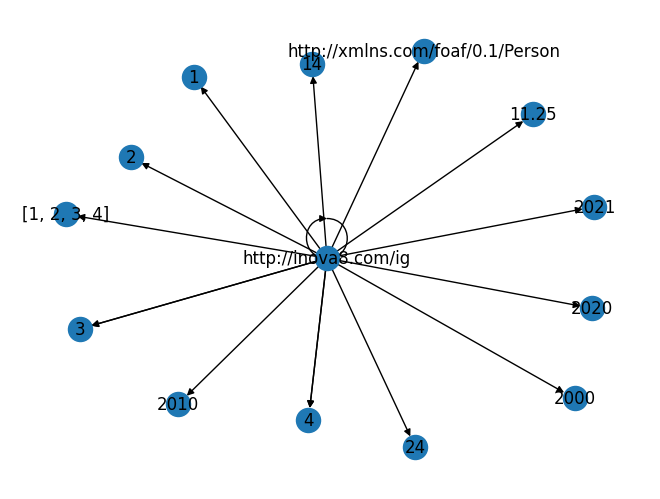

In [25]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph,rdflib_to_networkx_graph
import networkx as nx
import matplotlib.pyplot as plt
G = rdflib_to_networkx_multidigraph(g, edge_attrs=lambda s,p,o: {})
#G = rdflib_to_networkx_graph(g)
# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
#edge_labels = nx.get_edge_attributes(G, 'r')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, pos, with_labels=True)

#if not in interactive mode for
plt.show()

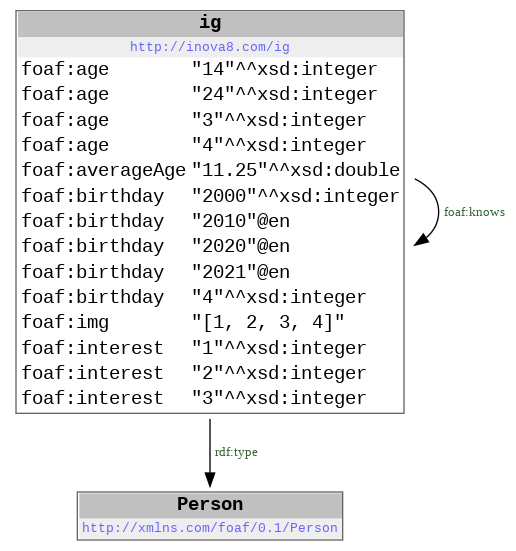

In [12]:
!pip install pydotplus
!pip install graphviz

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)